In [28]:
from sea_breeze import load_model_data, sea_breeze_funcs, sea_breeze_filters, utils
from dask.distributed import Client
from dask.distributed import progress
import xarray as xr
import pandas as pd
import numpy as np
import os
import argparse
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy

In [16]:
client = Client()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39745 instead
  warnings.warn(


Modifying workers


/g/data/hh5/public/apps/dask-optimiser/schedplugin.py:160: UserWarning: Attempted illegal binding: []
  warn(f"Attempted illegal binding: {(sorted(list(self.slots_available - taken_slots))[:self.worker.state.nthreads])}")
/g/data/hh5/public/apps/dask-optimiser/schedplugin.py:160: UserWarning: Attempted illegal binding: []
  warn(f"Attempted illegal binding: {(sorted(list(self.slots_available - taken_slots))[:self.worker.state.nthreads])}")
/g/data/hh5/public/apps/dask-optimiser/schedplugin.py:160: UserWarning: Attempted illegal binding: []
  warn(f"Attempted illegal binding: {(sorted(list(self.slots_available - taken_slots))[:self.worker.state.nthreads])}")
/g/data/hh5/public/apps/dask-optimiser/schedplugin.py:160: UserWarning: Attempted illegal binding: []
  warn(f"Attempted illegal binding: {(sorted(list(self.slots_available - taken_slots))[:self.worker.state.nthreads])}")
/g/data/hh5/public/apps/dask-optimiser/schedplugin.py:160: UserWarning: Attempted illegal binding: []
  warn(f"A

In [17]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0021.gadi.nci.org.au/50224/proxy/39745/status,
Dashboard: /node/gadi-cpu-bdw-0021.gadi.nci.org.au/50224/proxy/39745/status,Workers: 7
Total threads: 7,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33819,Workers: 7
Dashboard: /node/gadi-cpu-bdw-0021.gadi.nci.org.au/50224/proxy/39745/status,Total threads: 7
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33859,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0021.gadi.nci.org.au/50224/proxy/42399/status,Memory: 0 B
Nanny: tcp://127.0.0.1:38465,


In [38]:
lat_slice, lon_slice = utils.get_perth_large_bounds()

In [39]:
t1 = "2016-01-06 06:00"
t2 = "2016-01-06 06:00"

In [40]:
chunks = {"time":1,"lat":-1,"lon":-1}

In [41]:
orog, lsm = load_model_data.load_aus2200_static(
    "mjo-elnino",
    lon_slice,
    lat_slice)
angle_ds = load_model_data.get_coastline_angle_kernel(
    lsm,
    compute=False,
    lat_slice=lat_slice,
    lon_slice=lon_slice,
    path_to_load="/g/data/gb02/ab4502/coastline_data/aus2200.nc",
    smooth=True,
    sigma=2)


In [42]:
aus2200_vas = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "vas",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "10min",
        chunks=chunks,
        staggered="lat",
        smooth=True,
        sigma=2),
          "10min")
aus2200_uas = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "uas",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "10min",
        chunks=chunks,
        staggered="lon",
        smooth=True,
        sigma=2),
          "10min")
aus2200_hus = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "hus",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "10min",
        chunks=chunks,
        smooth=True,
        sigma=2),
          "10min")

#Just do the hourly data
aus2200_vas = aus2200_vas.sel(time=aus2200_vas.time.dt.minute==0)
aus2200_uas = aus2200_uas.sel(time=aus2200_uas.time.dt.minute==0)
aus2200_hus = aus2200_hus.sel(time=aus2200_hus.time.dt.minute==0)

In [ ]:
in1 = aus2200_hus.sel(time=t).values

conv_filter = np.zeros((3,3))
conv_filter[1,1] = 1/2
conv_filter[0,1] = 1/8
conv_filter[1,0] = 1/8
conv_filter[2,1] = 1/8
conv_filter[1,2] = 1/8
conv_filter

N = 100
for N in range(N):
    in1 = scipy.signal.convolve(in1,conv_filter,mode="same")

plt.pcolormesh(in1[1:,1:],vmin=0.008, vmax=0.015); plt.colorbar()

In [ ]:
in1 = aus2200_hus.sel(time=t).values

plt.pcolormesh(scipy.ndimage.uniform_filter(in1,20),vmin=0.008, vmax=0.015); plt.colorbar()

In [ ]:
in1 = aus2200_hus.sel(time=t).values

plt.pcolormesh(scipy.ndimage.gaussian_filter(in1,5),vmin=0.008, vmax=0.015); plt.colorbar()

In [44]:
Fc = sea_breeze_funcs.coast_relative_frontogenesis(
        aus2200_hus,
        aus2200_uas,
        aus2200_vas,
        angle_ds["angle_interp"]
    )

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 12.50 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


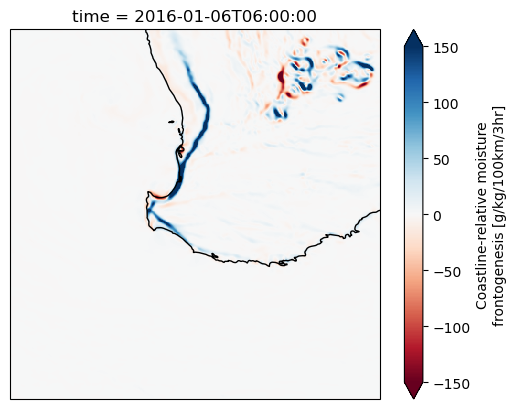

In [45]:
ax = plt.axes(projection=ccrs.PlateCarree())
Fc.Fc.plot(cmap="RdBu",vmin=-150,vmax=150)
ax.coastlines()

In [64]:
def gaussian_filter_time_slice(time_slice,sigma):
    out_ds = xr.DataArray(scipy.ndimage.gaussian_filter(time_slice.squeeze(), sigma),
                          dims=time_slice.squeeze().dims, coords=time_slice.squeeze().coords)
    # out_ds = xr.DataArray(scipy.ndimage.uniform_filter(time_slice.squeeze(), sigma),
    #                       dims=time_slice.squeeze().dims, coords=time_slice.squeeze().coords)
    
    out_ds = out_ds.expand_dims("time")
    out_ds["time"] = time_slice.time
    return out_ds

def smooth_angles(angles):
    z = np.exp(1j * np.deg2rad(angles))
    z = np.rad2deg(np.angle(scipy.ndimage.gaussian_filter(z, sigma=5))) % 360
    return z

s=4
aus2200_hus_smooth = aus2200_hus.map_blocks(
    gaussian_filter_time_slice,
    kwargs={"sigma":s},
    template=aus2200_hus)
aus2200_uas_smooth = aus2200_uas.map_blocks(
    gaussian_filter_time_slice,
    kwargs={"sigma":s},
    template=aus2200_uas)
aus2200_vas_smooth = aus2200_vas.map_blocks(
    gaussian_filter_time_slice,
    kwargs={"sigma":s},
    template=aus2200_vas)
angles_smooth = xr.apply_ufunc(smooth_angles, angle_ds["angle_interp"])

In [65]:
Fc_smooth = sea_breeze_funcs.coast_relative_frontogenesis(
        aus2200_hus_smooth,
        aus2200_uas_smooth,
        aus2200_vas_smooth,
        angles_smooth
    ).sel(time=t)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 12.50 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 12.47 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


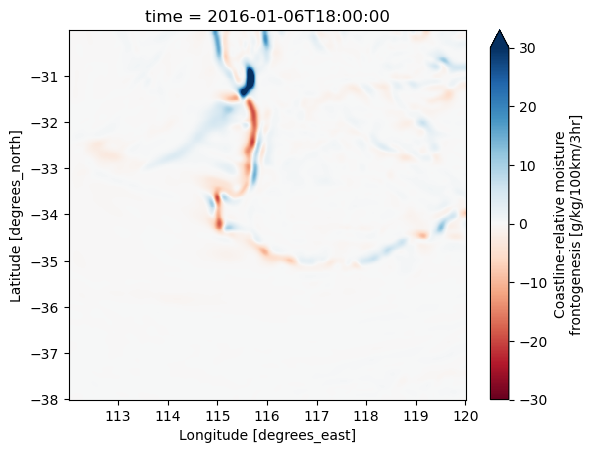

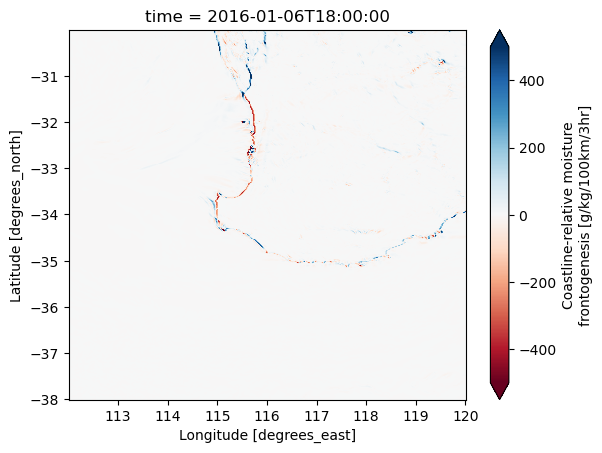

In [66]:
Fc_smooth.Fc.plot(vmin=-30,vmax=30,cmap="RdBu")
plt.figure()
Fc.Fc.plot(vmin=-500,vmax=500,cmap="RdBu")

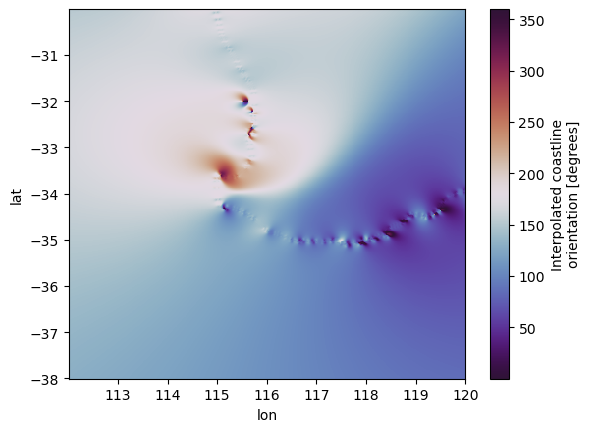

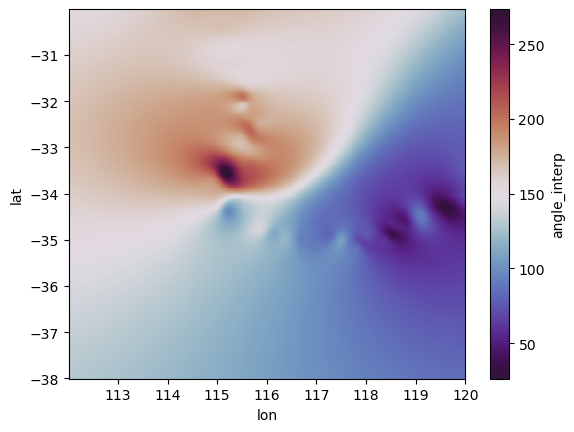

In [70]:
angle_ds["angle_interp"].plot(cmap="twilight_shifted")
plt.figure()
angles_smooth.plot(cmap="twilight_shifted")

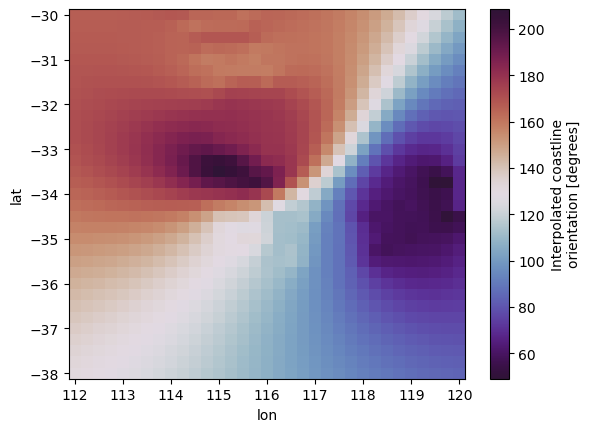

In [74]:
load_model_data.get_coastline_angle_kernel(
    None,
    compute=False,
    lat_slice=lat_slice,
    lon_slice=lon_slice,
    path_to_load="/g/data/gb02/ab4502/coastline_data/era5.nc").angle_interp.plot(cmap="twilight_shifted")